In [1]:
import numpy as np
from matplotlib import pyplot
from scipy.optimize import minimize

In [2]:
def model_function_imag(fix_arg, params):
    # params is a list or array of parameters for the model
    dw,w0 = fix_arg #angular frequency [2pi*GHz]
    Rt,Lt,a,b,Z1_r,Z1_i = params #fitting parameters
    
    Z1 = Z1_r + 1j * Z1_i
    gamma = a+b*1j
    
    Z = (Rt+2*1j*dw*Lt) #impedence of the circuit around the resonate frequency
    Z0 = 50.0 #characteristic impedence of transmission line
    
    return (2*Z *Z0 *Z1)/((Z0*np.cosh(gamma) + Z1*np.sinh(gamma))*((2*Z + Z0)*Z1*np.cosh(gamma) + (2*Z*Z0 + Z1*np.conjugate(Z1))*np.sinh(gamma)))



def loss_function_imag(params, fix_arg, S21):
    #dw,w0 = fix_arg
    predictions = model_function_imag(fix_arg, params)
    return np.sum(abs(predictions - S21))  




In [3]:
from nptdms import TdmsFile

# Load TDMS file
tdms_file = TdmsFile.read("./SA40515J.20240123.000295.tdms")

# Access a specific channel
group = tdms_file['Data.000000']  
channel = group['ReS21'] 
ReS21 = channel[:]
channel = group['ImS21'] 
ImS21 = channel[:]

S21_013 = ReS21 + ImS21*1j
channel = group['frequency'] 
freq = channel[:]/np.pi/2/1e9
# # Get data from the channel

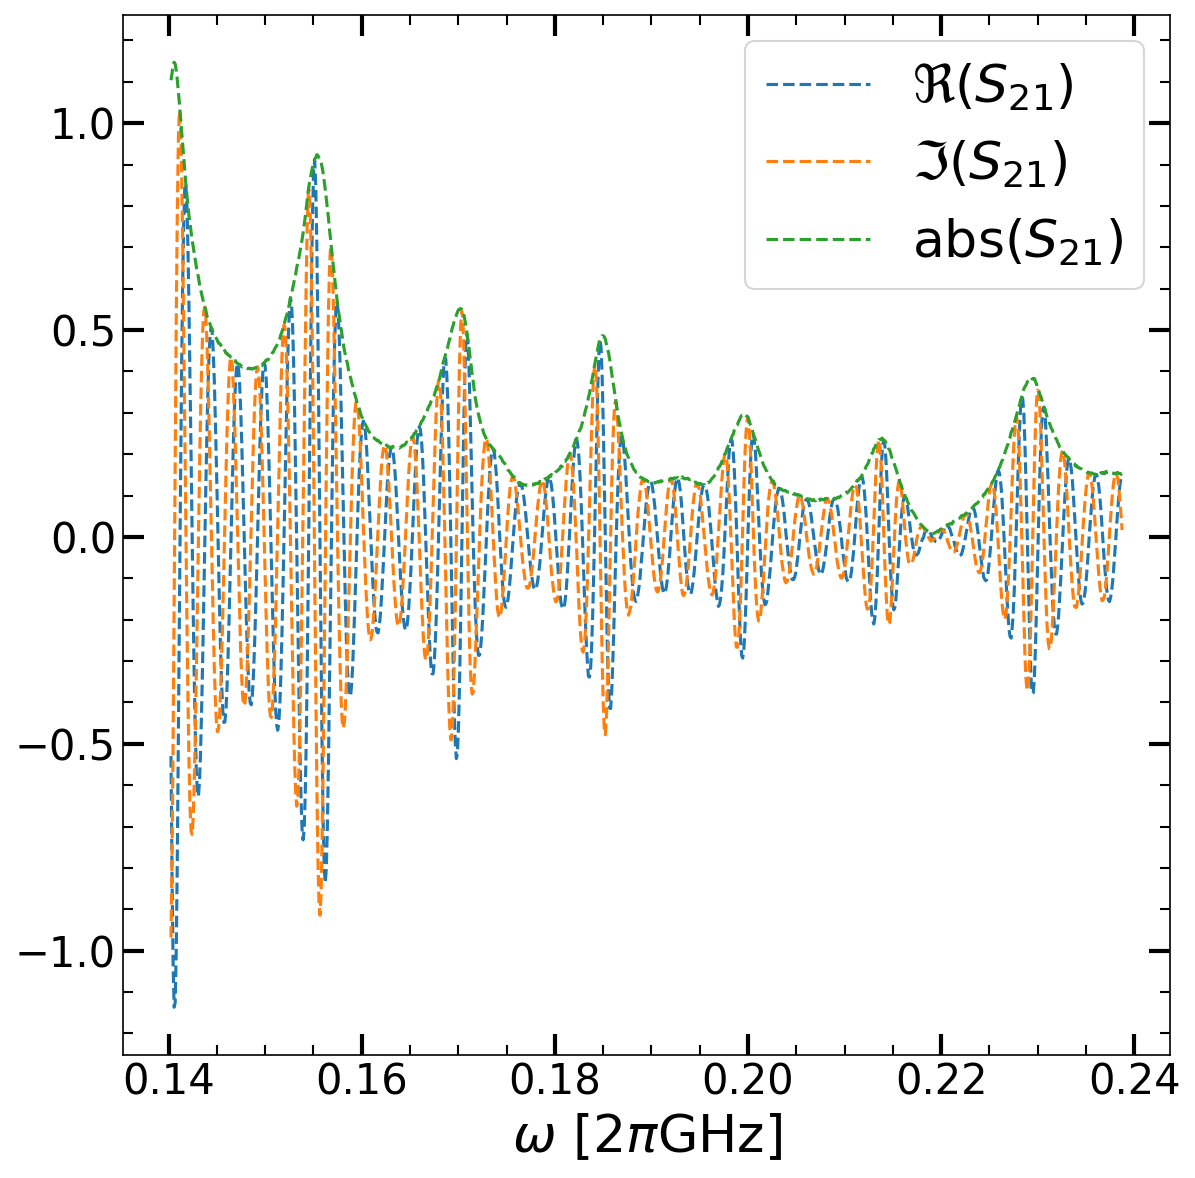

In [4]:
pyplot.figure(figsize=(9,9),dpi = 150)



pyplot.xlabel('$\omega$ [$2\pi$GHz]',size = 25)

pyplot.plot(freq[700:],np.real(S21_013)[700:],'--',label = '$\Re(S_{21})$')
pyplot.plot(freq[700:],np.imag(S21_013)[700:],'--',label = '$\Im(S_{21})$')
pyplot.plot(freq[700:],np.abs(S21_013)[700:],'--',label = '$\mathrm{abs}(S_{21})$')


pyplot.xticks(size = 20)
pyplot.yticks(size = 20)

pyplot.tick_params(axis='y', which='major', direction='in', right=True, width=2,length = 10)
pyplot.tick_params(axis='y', which='minor', direction='in', right=True, width=1,length = 5)
pyplot.tick_params(axis='x', which='major', direction='in', top = True, width=2,length = 10)
pyplot.tick_params(axis='x', which='minor', direction='in', top = True, width=1,length = 5)
pyplot.minorticks_on()
pyplot.legend(prop={'size':25})

pyplot.show()

In [5]:
S21_a = ReS21 + 1j*ImS21
S21_a = S21_a/np.exp(-1j*2*np.pi*freq*380)#get rid of high frequency oscillation

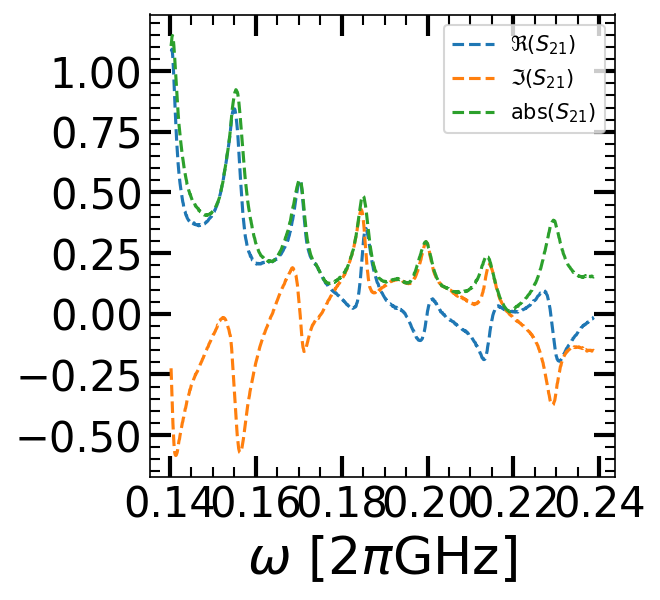

In [14]:
pyplot.figure(figsize=(4,4),dpi = 150)



pyplot.xlabel('$\omega$ [$2\pi$GHz]',size = 25)

pyplot.plot(freq[700:],np.real(S21_a)[700:],'--',label = '$\Re(S_{21})$')
pyplot.plot(freq[700:],np.imag(S21_a)[700:],'--',label = '$\Im(S_{21})$')
pyplot.plot(freq[700:],np.abs(S21_a)[700:],'--',label = '$\mathrm{abs}(S_{21})$')


pyplot.xticks(size = 20)
pyplot.yticks(size = 20)

pyplot.tick_params(axis='y', which='major', direction='in', right=True, width=2,length = 10)
pyplot.tick_params(axis='y', which='minor', direction='in', right=True, width=1,length = 5)
pyplot.tick_params(axis='x', which='major', direction='in', top = True, width=2,length = 10)
pyplot.tick_params(axis='x', which='minor', direction='in', top = True, width=1,length = 5)
pyplot.minorticks_on()
pyplot.legend(prop={'size':10})

pyplot.show()

In [7]:
#fitting region
S21_s = S21_a[1400:1445]
freq_s = freq[1400:1445]
idx = np.where(np.abs(S21_s) == min(np.abs(S21_s)))[0][0]

w0 = freq_s[idx]
dw = freq_s-w0

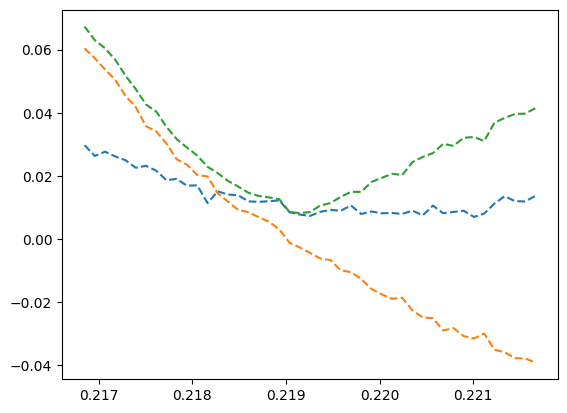

In [8]:
pyplot.plot(freq_s,np.real(S21_s),'--')
pyplot.plot(freq_s,np.imag(S21_s),'--')
pyplot.plot(freq_s,np.abs(S21_s),'--')

In [ ]:
# Fitting and Extrema finding

Rt = 2
Lt  = 1
a = 1
b = 3
Z1_r = 10
Z1_i = 10
#please try multiple initial parameters to get the best fit

initial_params = [  Rt,Lt,a,b,Z1_r,Z1_i]

result = minimize(loss_function_imag, initial_params, args=((dw,w0),np.conj(S21_s)),bounds = [(1e-6,None),(None,None),(1e-6,None),(None,None),(1e-6,None),(None,None)],
                  method='Nelder-Mead', options={'maxiter': 10000})
#I found it is necessary to fit the complex conjugate of the S21 curve. Probabily because of mismatch of the direction in experiment and simulation.

print(result.success,result.x)
print("Q = " + str(w0*result.x[1]/result.x[0]))
print("loss = " + str(result.fun))
print(w0, result)


True [ 1.12679255e+01  1.08242961e+04  1.48900046e-02  3.14138134e+00
  3.51927004e+03 -2.03518830e+04]
Q = 210.51839709514786
loss = 0.10279630536449902
0.21914640945359665        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.10279630536449902
             x: [ 1.127e+01  1.082e+04  1.489e-02  3.141e+00  3.519e+03
                 -2.035e+04]
           nit: 2045
          nfev: 3228
 final_simplex: (array([[ 1.127e+01,  1.082e+04, ...,  3.519e+03,
                        -2.035e+04],
                       [ 1.127e+01,  1.082e+04, ...,  3.519e+03,
                        -2.035e+04],
                       ...,
                       [ 1.127e+01,  1.082e+04, ...,  3.519e+03,
                        -2.035e+04],
                       [ 1.127e+01,  1.082e+04, ...,  3.519e+03,
                        -2.035e+04]]), array([ 1.028e-01,  1.028e-01,  1.028e-01,  1.028e-01,
                        1.028e-01,  1.028e-01,  1.028e-01]))

In [10]:
S_test = model_function_imag(fix_arg=(dw,w0), params =result.x)

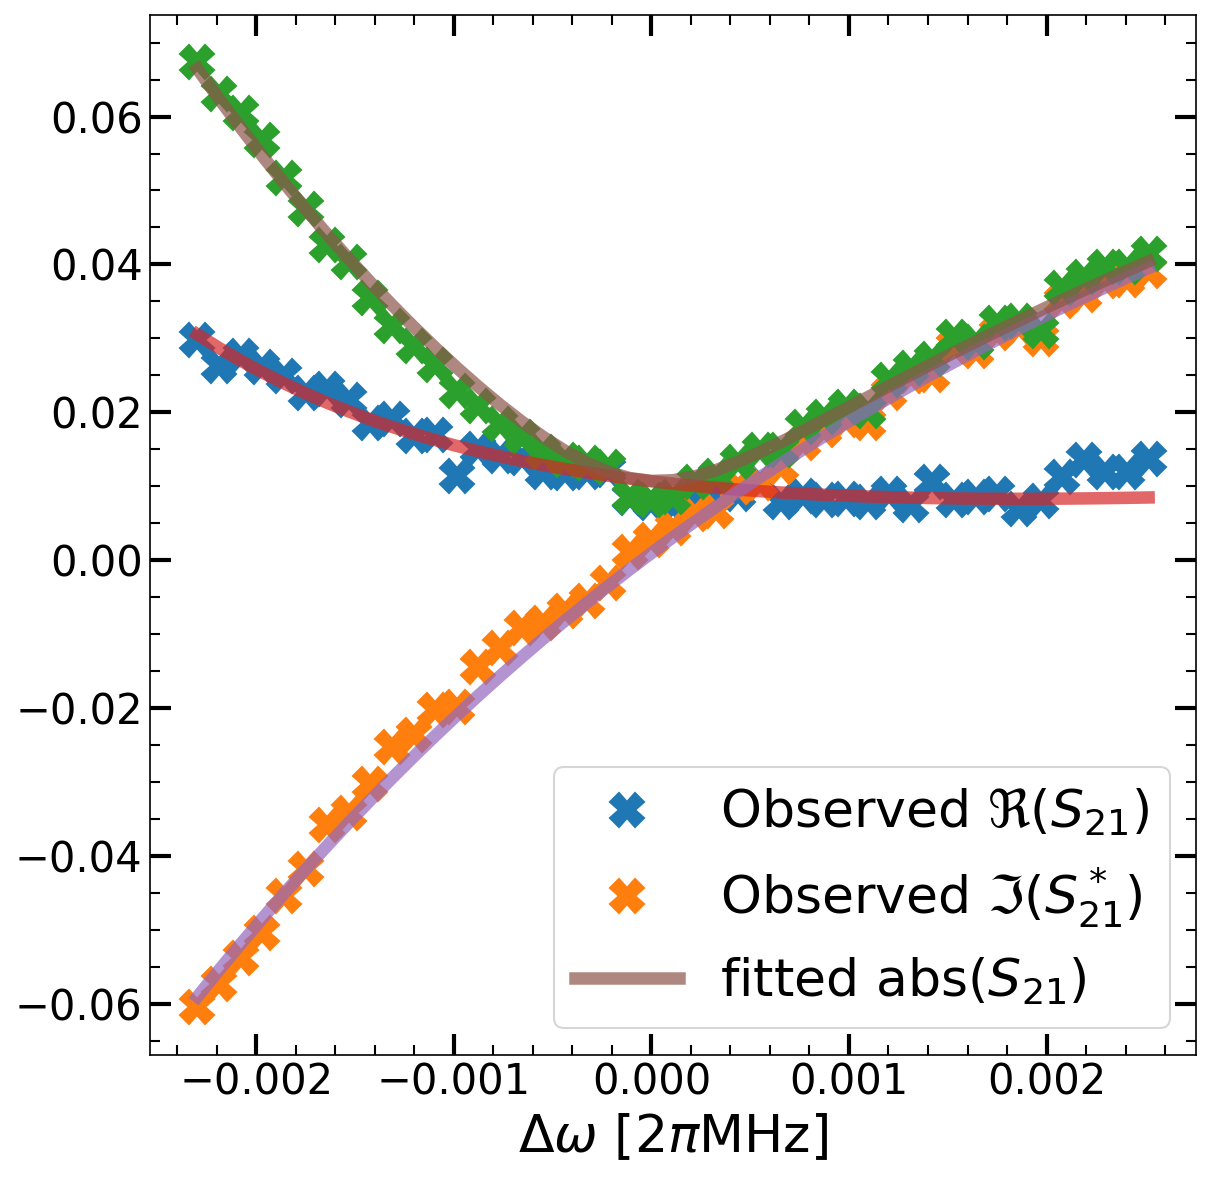

In [11]:
pyplot.figure(figsize=(9,9),dpi = 150)



pyplot.xlabel('$\Delta \omega$ [2$\pi$MHz]',size = 25)


pyplot.plot(dw,np.real(S21_s),'X',label = "Observed $\Re(S_{21})$",markersize = 16)
pyplot.plot(dw,-np.imag(S21_s),'X',label = "Observed $\Im(S_{21}^*)$",markersize = 16)
pyplot.plot(dw,np.abs(S21_s),'X',markersize = 16)

pyplot.plot(dw,np.real(S_test),'-',linewidth = 6,alpha = 0.7)
pyplot.plot(dw,np.imag(S_test),'-',linewidth = 6,alpha = 0.7)

pyplot.plot(dw,np.abs(S_test),'-',label = "fitted $\mathrm{abs}(S_{21})$",linewidth = 6,alpha = 0.7)


pyplot.xticks(size = 20)
pyplot.yticks(size = 20)

pyplot.tick_params(axis='y', which='major', direction='in', right=True, width=2,length = 10)
pyplot.tick_params(axis='y', which='minor', direction='in', right=True, width=1,length = 5)
pyplot.tick_params(axis='x', which='major', direction='in', top = True, width=2,length = 10)
pyplot.tick_params(axis='x', which='minor', direction='in', top = True, width=1,length = 5)
pyplot.minorticks_on()
pyplot.legend(prop={'size':25})

pyplot.show()